In [1]:
import numpy as np
import importlib
import sys
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Parallel_Simulation')
from Data_Treatement import *
import matplotlib.pyplot as plt
media = "/media/hcleroy/Simulation_Res/Parallel_Simulation_aging/fixed_density/"
from scipy.special import erfc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
def sliding_average(X, Y, window_size=5):

    half_window = window_size // 2
    
    # Initialize smoothed Y array
    Y_smooth = np.convolve(Y, np.ones(window_size)/window_size, mode='valid')
    
    # Adjust X to match the size of the smoothed Y array
    # This centers the window on the point being averaged
    start_index = (window_size - 1) // 2
    end_index = start_index + len(Y_smooth)
    X_smooth = X[start_index:end_index]
    
    return X_smooth, Y_smooth
avR = lambda L,N : 2*(np.exp(-1.5/(L/N)) * np.sqrt(L/N*6/np.pi)*(3+2*L/N) - 9*erfc(np.sqrt(3/2/(L/N))))/(9*L/N) #average distance between equilibrated nodes
Lcharact = lambda L,N : (np.sqrt(2*L/N/3))

import pandas as pd
from scipy.optimize import curve_fit

In [3]:
density = 'mu5e_2_'
Names = ['N5','N10','N25','N50']
N = [5,10,25,50,100]
L = [100,200,500,1000,2000]
clusters = list()
for name in Names:
    #print(name)
    clusters.append(Data_Treatement(media+density+name+'.hdf',data_type='cluster'))
media_2 = "/media/hcleroy/Simulation_Res/Cluster/N/100/mu5e_2/"
file_2 = "E-15_N100_ell2E3_kdiffE-3.hdf"
clusters.append(Data_Treatement(media_2+file_2,data_type='cluster'))
#media_3 = "/media/hcleroy/Simulation_Res/Cluster/N/100/mu1e_2/"
#file_3 = "E-15_N100_ellE4_kdiffE-3.hdf"
#clusters.append(Data_Treatement(media_3+file_3,data_type='cluster'))
for cluster  in clusters:
    cluster.average(num_bins=70,log_scale=True)

In [2]:
density = 'mu5e_2_'
Names = ['N5','N10','N25','N50']#,'N100']
N = [5,10,25,50,100]
L = [100,200,500,1000,2000]
isfs = list()
for name in Names:
    #print(name)
    isfs.append(Data_Treatement(media+density+name+'.hdf',data_type='ISF'))

media_2 = "/media/hcleroy/Simulation_Res/Cluster/N/100/mu5e_2/"
file_2 = "E-15_N100_ell2E3_kdiffE-3.hdf"
isfs.append(Data_Treatement(media_2+file_2,data_type='ISF'))
for isf  in isfs:
    isf.average(num_bins=70,log_scale=True)

N5
N10
N25
N50
0


/home/hcleroy/PostDoc/aging_condensates/Simulation/Parallel_Simulation/Data_Treatement.py:280: RuntimeWarning: invalid value encountered in divide
  weighted_average /=count


1
2
3
4


In [4]:
time_shifts = list()
for name in Names:
    time_shift = Data_Treatement(media+density+name+'.hdf',data_type='Time_shift')
    time_shifts.append( np.mean(time_shift.data,axis=0))
time_shift = Data_Treatement(media_2+file_2,data_type='Time_shift')
time_shifts.append( np.mean(time_shift.data,axis=0))

In [5]:
#s_exp = lambda t,A,alpha,tau : A*np.exp(-(t/tau)**alpha) if alpha>0 else 0
def s_exp (t,A,alpha,tau):
    if tau>0 and A<=1.5:
        return A*np.exp(-(t/tau)**alpha)
    else:
        return 0.
params = list()
for isf in isfs:
    param=list()
    i=0
    for time,data in zip(isf.binned_time,isf.average_data):
        #print(time)
        #print(isf)
        s = pd.Series(data)
        # Use linear interpolation to fill NaNs
        s = s.interpolate(method='linear')
        # Convert back to a numpy array if needed
        data = s.to_numpy()
        popt,pconv = curve_fit(s_exp,time,data,p0 = (1,1,1000))
        param.append(popt)
    param= np.array(param)
    params.append(param)

In [6]:
params.__len__()

5

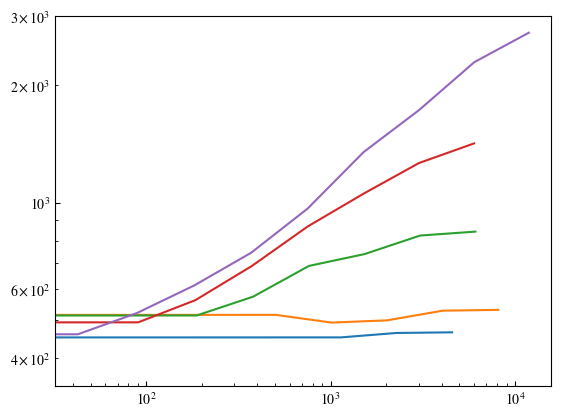

In [7]:
for time_shift,param in zip(time_shifts,params):
    plt.plot(time_shift[:],param[:,2])
plt.yscale('log')
plt.xscale('log')

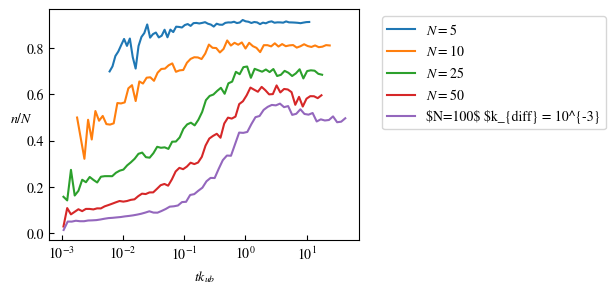

In [8]:
fig,ax = plt.subplots(figsize=(4,3))
KDIFF = [10**-3,10**-3,10**-3,10**-3,10**-3,10**-4,10**-3]
labels = [r'$N = 5$',r'$N=10$',r'$N=25$',r'$N=50$',r'$N=100$ $k_{diff} = 10^{-3}']
n=0
for cluster in clusters:#[i:i+1]):
    X,Y = cluster.binned_time,cluster.average_data[:,0]
    if n ==1:
        Y[1] = 0.5*(Y[0]+Y[2])
    #X,Y = sliding_average(X,Y,2)
    ax.plot(X*KDIFF[n],Y/N[n],label=labels[n])
    #ax.plot(X*KDIFF[n],Y,label=labels[n])
    n+=1

ax.set_xscale('log')    

ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_xlabel(r'$tk_{ub}$')
ax.set_ylabel(r'$n/N$',rotation=0)

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

#plt.savefig('cluster_evolution.svg',transparent=True,bbox_inches='tight')

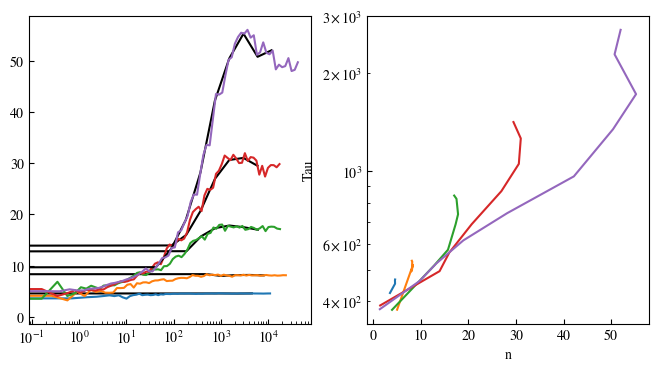

In [10]:
from scipy.interpolate import interp1d
fig,ax = plt.subplots(ncols=2,figsize=(8,4))
for n in range(clusters.__len__()):
    x,y = clusters[n].binned_time,clusters[n].average_data[:,0]
    x = x-x[0]
    f = interp1d(x, y, kind='quadratic')

    Xin = time_shifts[n].astype(float)

    Yout = f(Xin)

    ax[0].plot(Xin,Yout,color='black')
    ax[0].plot(x,y)
    ax[0].set_xscale('log')

    ax[1].plot(Yout,params[n][:,2])
    #ax[1].plot(Yout,np.exp(Yout/10)/Yout*2*10**3)
    ax[1].set_yscale('log')
    ax[1].set_xlabel('n')
    ax[1].set_ylabel('Tau')

In [25]:
clusters[-1].data[:,:,0].shape

(10, 1000000)

In [36]:
# check the cluster growth of the 10**-4 
#for x,y in zip(clusters[-1].time[:1],clusters[-1].data[:1,:,0]):
#    plt.scatter(x,y,color='black',s=0.1)
fig = plt.figure(figsize=(9,9))
ax = scatter_density(fig,clusters[-1].time.astype(float).flatten(),clusters[-1].data[:,:,0].astype(float).flatten(),nrows=1,ncols=1,pos=1,dpi=10,xlim=None,ylim=None,norm=True,resample=True,LogStretch=None,vmin=0,vmax=5)
#plt.xscale('log')


: 